In [1]:
# 1. For i in front/*; do imagemagick/convert 300x300px ...
# 2. Del all images with 2kb (sort, manual, Windows Explorer)
# 3. Basic Preparation Data with bash
#    cat sentencing.csv | sed -e 's/LIFE/100/g' |awk -F\; '{print $1 " " $7}'| awk 'BEGIN {id="id"; yrs="years"} id != $1 {print id","yrs; id=$1; yrs=$2 } id != "id" {yrs = yrs + $2}' >id_years.csv

# Images and Pre-Trained model files are large
rootdir='C:\\Users\\Sandow\\Documents\\CAS AML Project\\cas-aml-prisioners'

import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

os.environ["PATH"] += os.pathsep + 'C:\\Program Files (x86)\\Graphviz\\bin'
os.environ["PATH"] += os.pathsep + 'C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v10.1\\lib\\x64'
os.environ["CUDA_PATH"] = 'C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v10.1\\'

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.list_physical_devices()

sentence_f='id_years2.csv'
sentence = pd.read_csv(sentence_f)
sentence.head()


Num GPUs Available:  1


,A00147,174
0,A00360,203
1,A00367,83
2,A01054,225
3,A01072,6265
4,A01077,16


In [2]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    ]
)

# small version of the Xception network
# https://keras.io/examples/vision/image_classification_from_scratch/
#
def make_model(input_shape, num_classes):
    from tensorflow.keras import layers
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block TODO Augmentation removed due to "invalid image file"
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128,256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [3]:
image_size = (300, 300)
batch_size = 16
imgDir=os.path.join(rootdir,'Prisioners')

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    imgDir,
    validation_split=0.3,
    subset="training",
    seed=4242,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    imgDir,
    validation_split=0.3,
    subset="validation",
    seed=4242,
    image_size=image_size,
    batch_size=batch_size,
)
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


Found 50025 files belonging to 4 classes.
Using 35018 files for training.
Found 50025 files belonging to 4 classes.
Using 15007 files for validation.


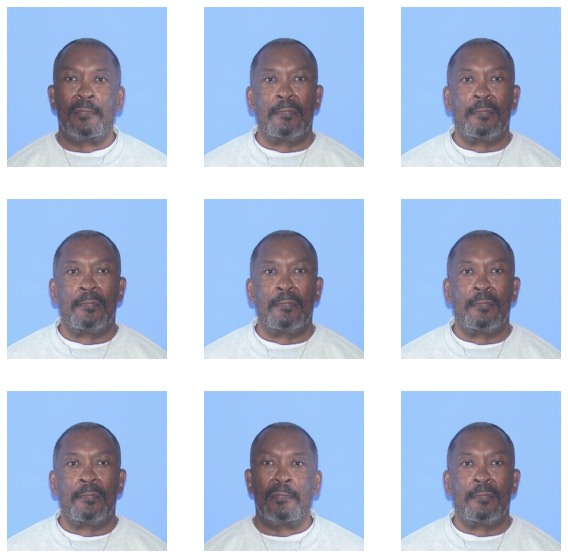

In [4]:
inputs = keras.Input(shape=(300,300,3))
x = data_augmentation(inputs)
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(x)
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [5]:
#model = make_model(input_shape=image_size + (3,), num_classes=4)
#keras.utils.plot_model(model, show_shapes=True)

In [6]:
epochs = 50

lr=1e-4
model = make_model(input_shape=image_size + (3,), num_classes=4)
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(lr),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
print("====> Current Learning Rate is ",lr)
history = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)
model.save(os.path.join(rootdir,"model-lr"+str(lr)))

====> Current Learning Rate is  0.0001
Epoch 1/50
2189/2189 [==============================] - 958s 438ms/step - loss: 2.2604 - accuracy: 0.2508 - val_loss: 2.2223 - val_accuracy: 0.2743
Epoch 2/50
2189/2189 [==============================] - 938s 429ms/step - loss: 2.2345 - accuracy: 0.2469 - val_loss: 2.2221 - val_accuracy: 0.2881
Epoch 3/50
2189/2189 [==============================] - 1034s 473ms/step - loss: 2.2295 - accuracy: 0.2505 - val_loss: 2.2221 - val_accuracy: 0.2883
Epoch 4/50
2189/2189 [==============================] - 971s 443ms/step - loss: 2.2272 - accuracy: 0.2481 - val_loss: 2.2221 - val_accuracy: 0.2531
Epoch 5/50
2189/2189 [==============================] - 938s 429ms/step - loss: 2.2269 - accuracy: 0.2486 - val_loss: 2.2221 - val_accuracy: 0.2143
Epoch 6/50
2189/2189 [==============================] - 934s 427ms/step - loss: 2.2269 - accuracy: 0.2539 - val_loss: 2.2221 - val_accuracy: 0.2751
Epoch 7/50
2189/2189 [==============================] - 938s 428ms/step 

InternalError: GPU sync failed